In [18]:
library(viridis)
library(scales)
library(ggplot2)
library(pheatmap)
library(picante)
library(plyr)

In [19]:
## running parallel processes.
library(doParallel)
registerDoParallel(cores=5)

In [20]:
getwd()

[1] "/tscc/projects/ps-renlab2/nzemke/multiome/hippocampus/40_donor_analysis/correlation_with_age"

In [21]:
cells <- c('Oligo', 'OPC', 'SUB', 'CA1', 'Macro', 'Endo', 'VLMC', 'CA2-CA3', 'SST', 'VIP', 'LAMP5', 'Chandelier', 'NR2F2', 'PVALB', 'T-Cell', 'Microglia', 'Astro', 'DG', 'Excitatory', 'Inhibitory')

In [22]:
age <- read.table('../../age.tsv')

In [6]:
celltype <- sprintf(cells[1])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [7]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [8]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [9]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [10]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [11]:
comb <- rbind(pcc, pcc_shuf)

In [12]:
dim(comb)

[1] 222590      2

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


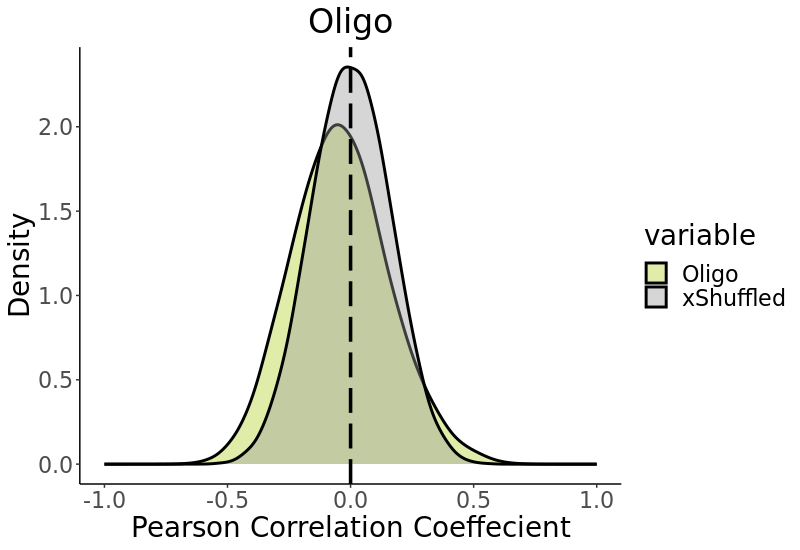

In [13]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [14]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'

In [15]:
pval$fdr <- p.adjust(pval$pval, "fdr")

In [16]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [17]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [18]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [19]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [20]:
dim(comb)

[1] 1470    6

In [21]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [22]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [23]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

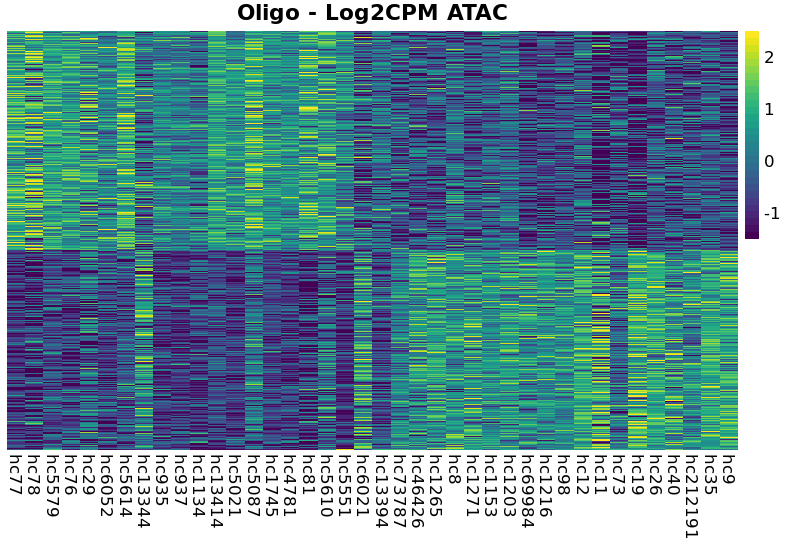

In [24]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [25]:
dim(comb)

[1] 1470   40

In [26]:
celltype <- sprintf(cells[2])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [27]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [28]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [29]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [30]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [31]:
comb <- rbind(pcc, pcc_shuf)

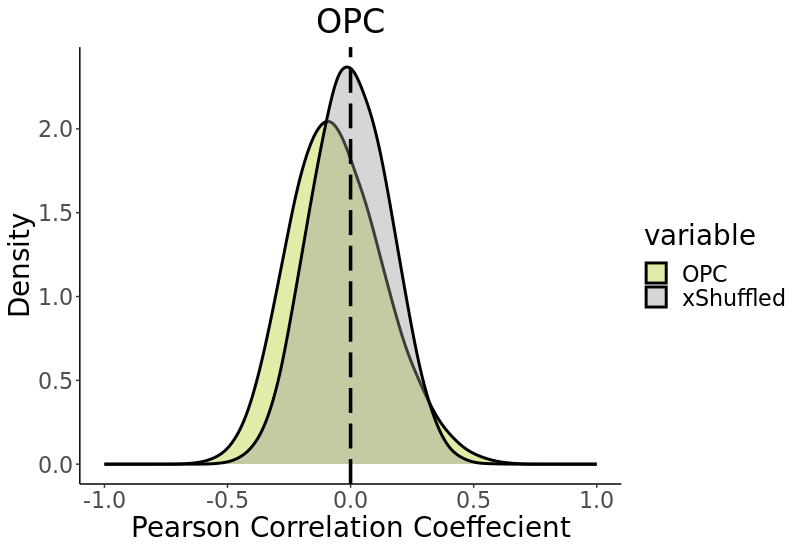

In [32]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [33]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [34]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [35]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [36]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [37]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [38]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [39]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [40]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

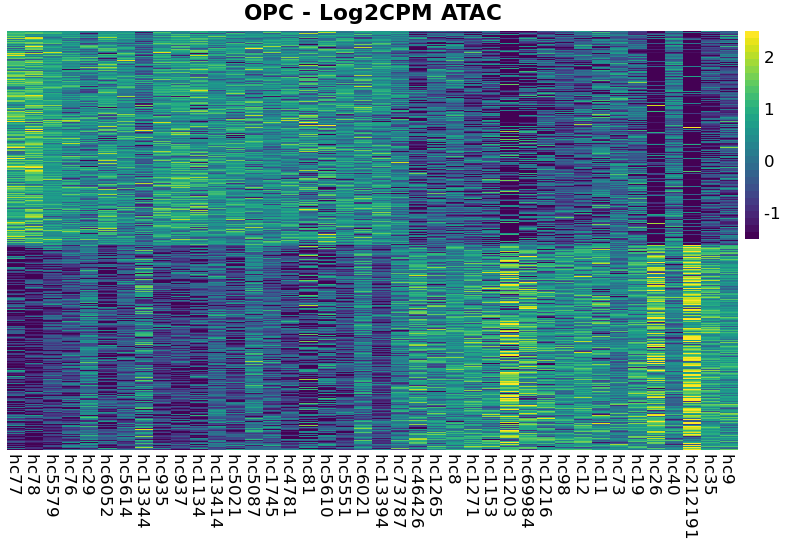

In [41]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [42]:
celltype <- sprintf(cells[3])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [43]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [44]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [45]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [46]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [47]:
comb <- rbind(pcc, pcc_shuf)

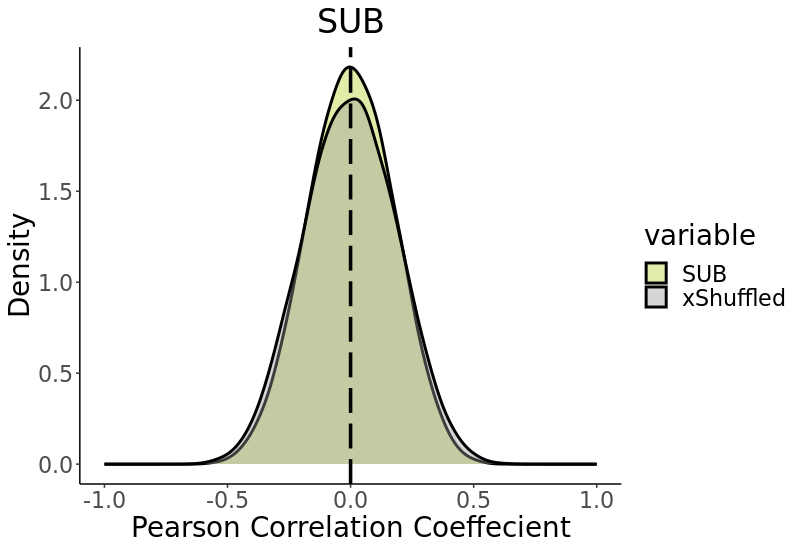

In [48]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [49]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [50]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [51]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [52]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [53]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [54]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [55]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [56]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

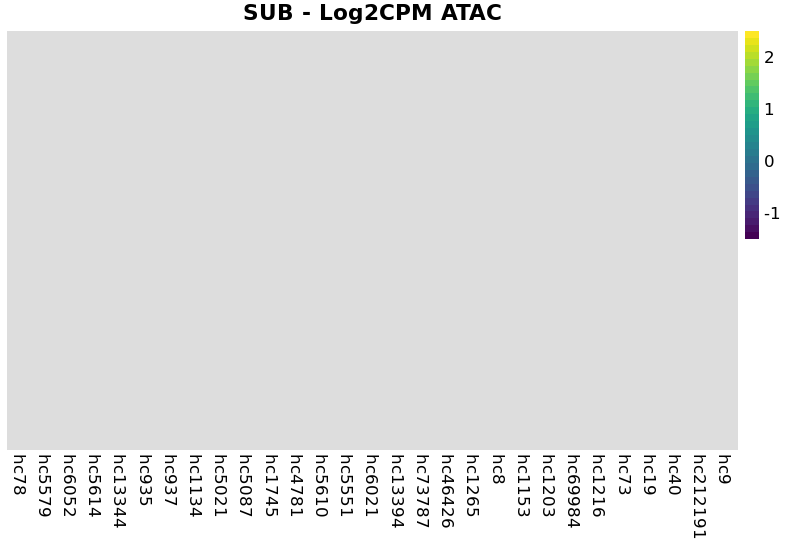

In [57]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [58]:
celltype <- sprintf(cells[4])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [59]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [60]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [61]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [62]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [63]:
comb <- rbind(pcc, pcc_shuf)

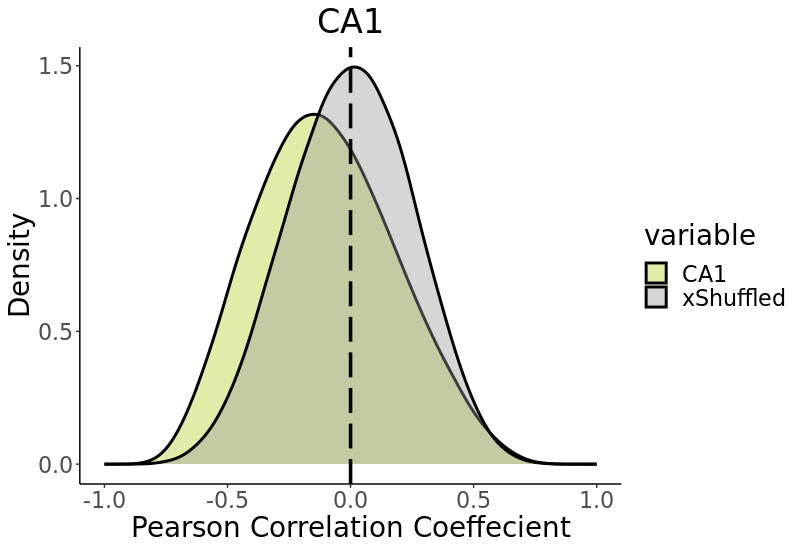

In [64]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [65]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [66]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [67]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [68]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [69]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [70]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [71]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [72]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

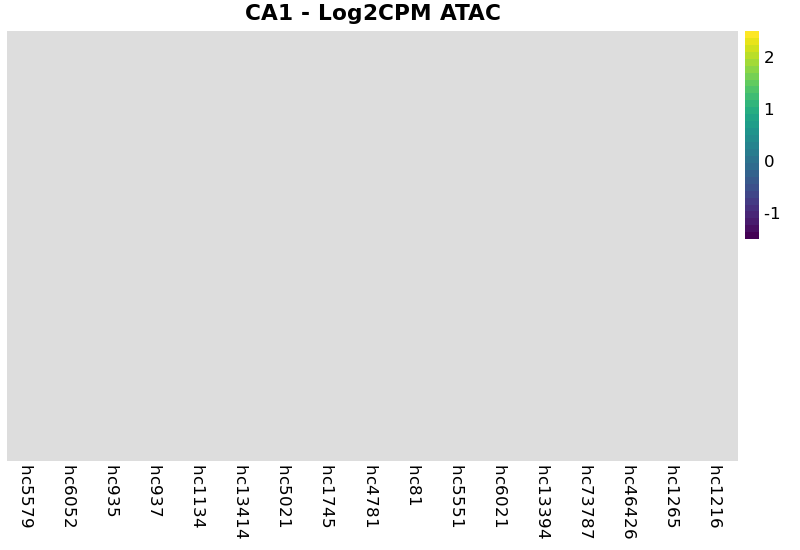

In [73]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [74]:
celltype <- sprintf(cells[5])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [75]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [76]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [77]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [78]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [79]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 910 rows containing non-finite values (`stat_density()`).”


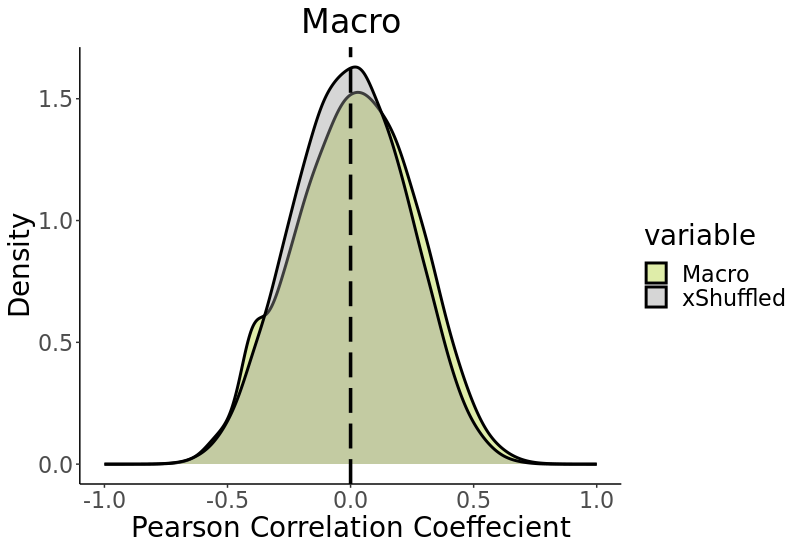

In [80]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [81]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [82]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [83]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [84]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [85]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [86]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [87]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [88]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

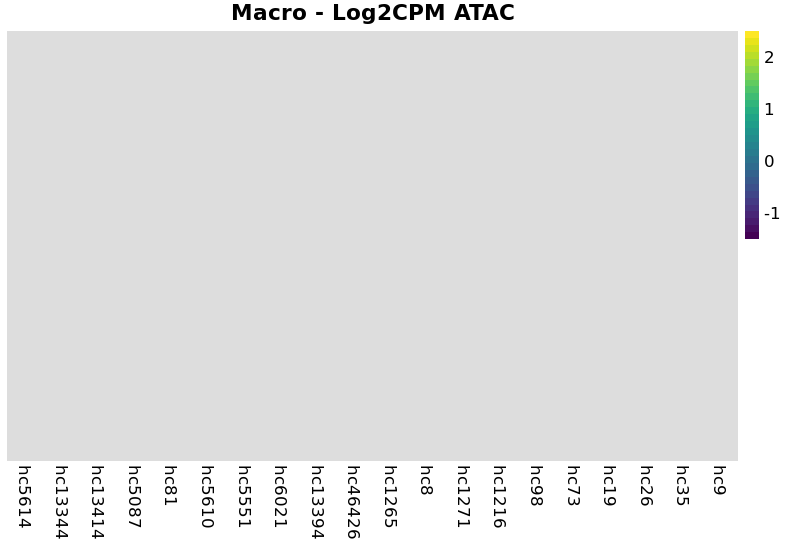

In [89]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [90]:
celltype <- sprintf(cells[6])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [91]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [92]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [93]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [94]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [95]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 286 rows containing non-finite values (`stat_density()`).”


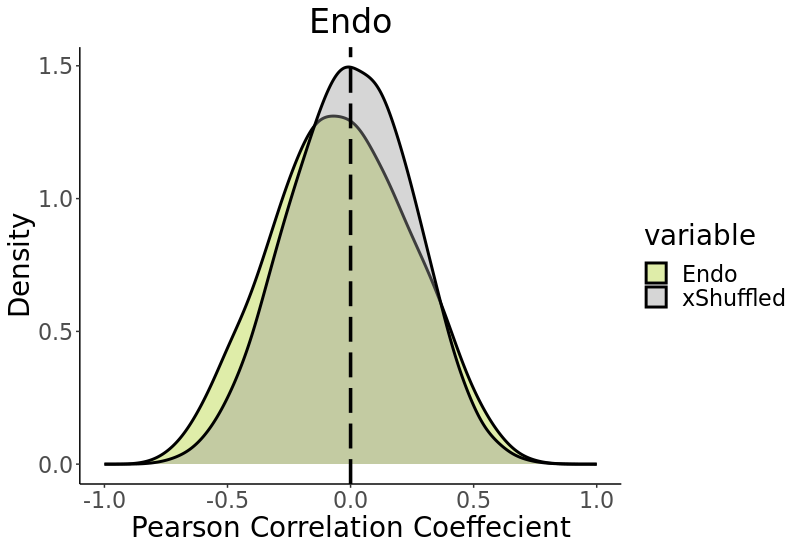

In [96]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [97]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [98]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [99]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [100]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [101]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [102]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [103]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [104]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

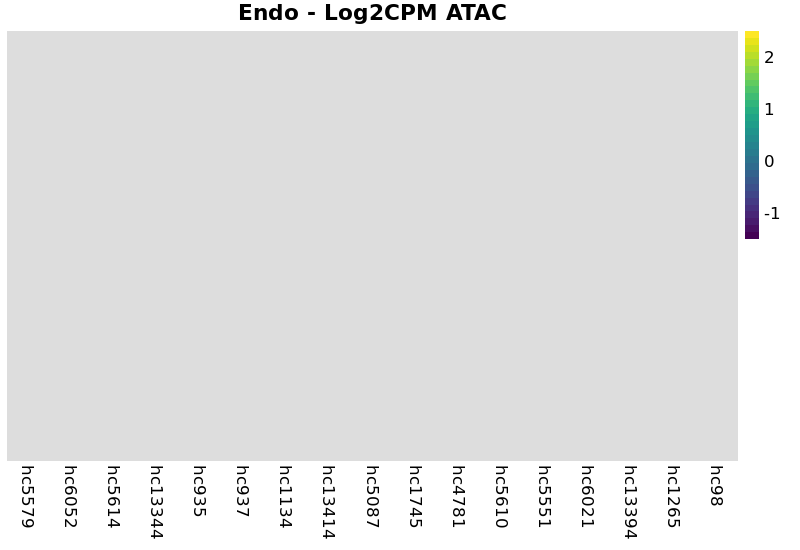

In [105]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [106]:
celltype <- sprintf(cells[7])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [107]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [108]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [109]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [110]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [111]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 110 rows containing non-finite values (`stat_density()`).”


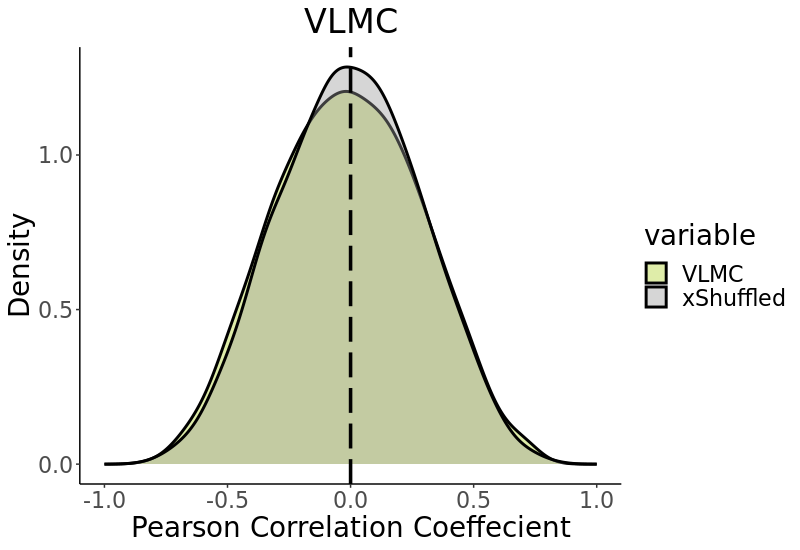

In [112]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [113]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [114]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [115]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [116]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [117]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [118]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [119]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [120]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

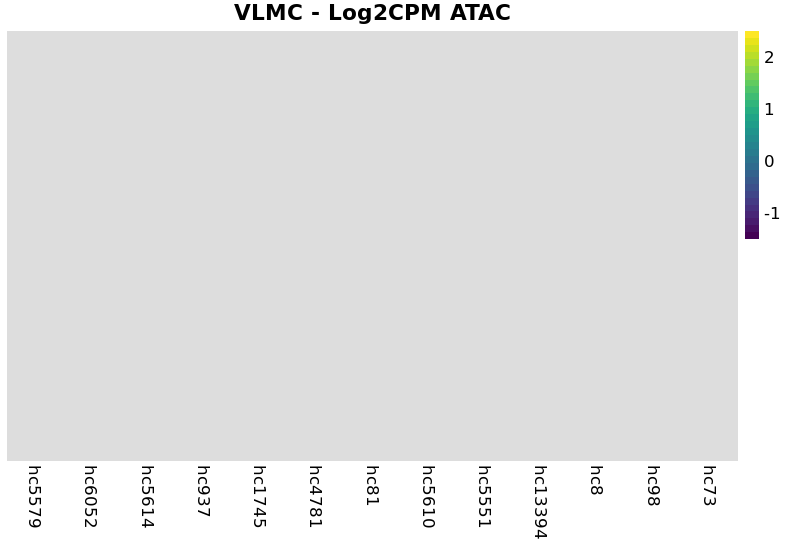

In [121]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [122]:
celltype <- sprintf(cells[8])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [123]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [124]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [125]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [126]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [127]:
comb <- rbind(pcc, pcc_shuf)

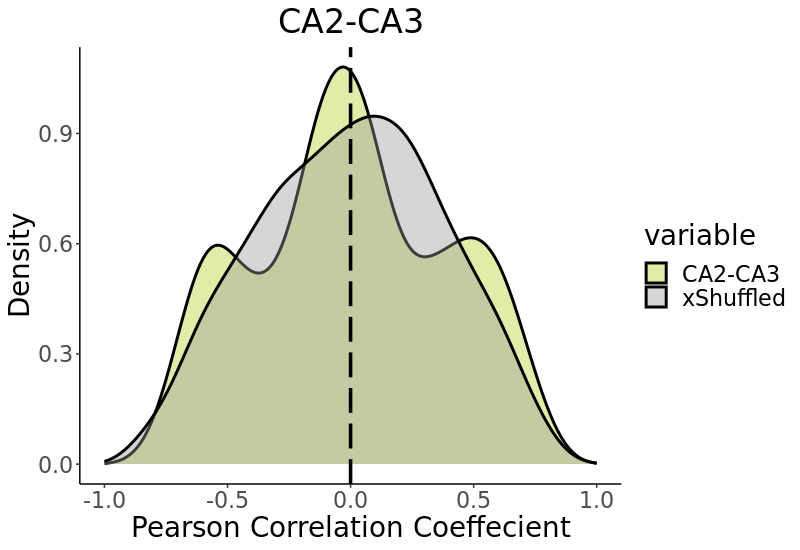

In [128]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [129]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [130]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [131]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [132]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [133]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [134]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [135]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [136]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

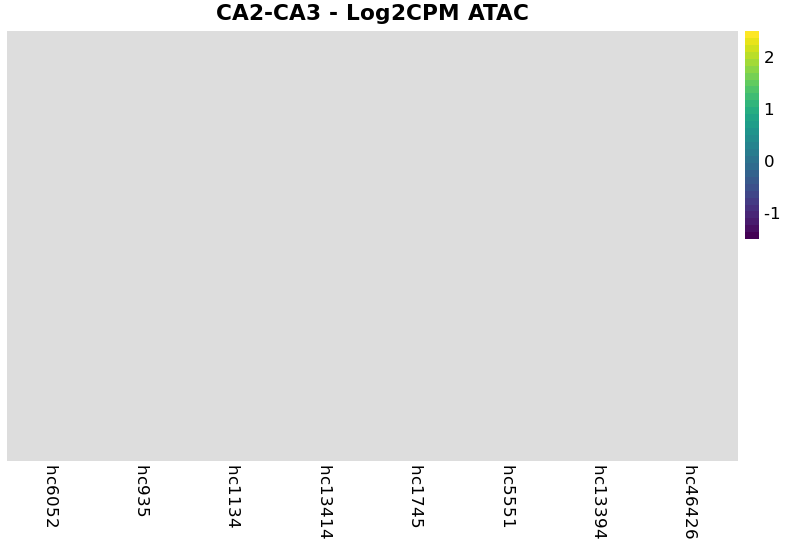

In [137]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [138]:
celltype <- sprintf(cells[9])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [139]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [140]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [141]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [142]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [143]:
comb <- rbind(pcc, pcc_shuf)

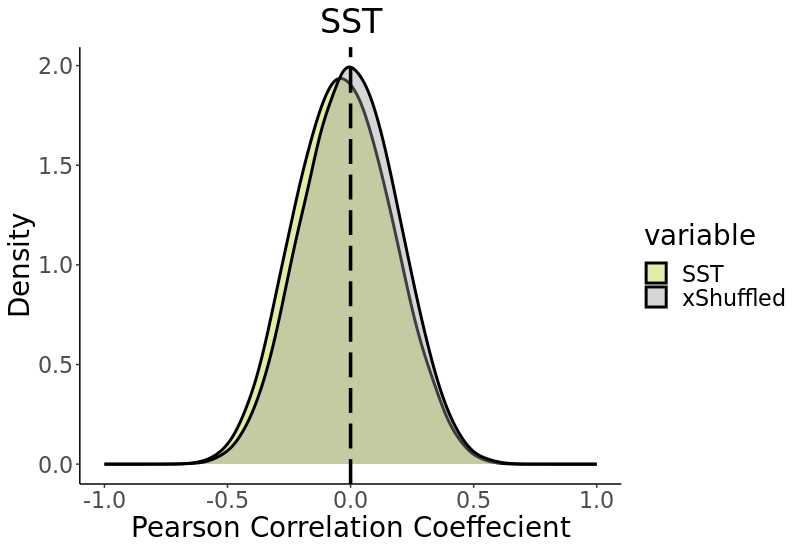

In [144]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [145]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [146]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [147]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [148]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [149]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [150]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [151]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [152]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

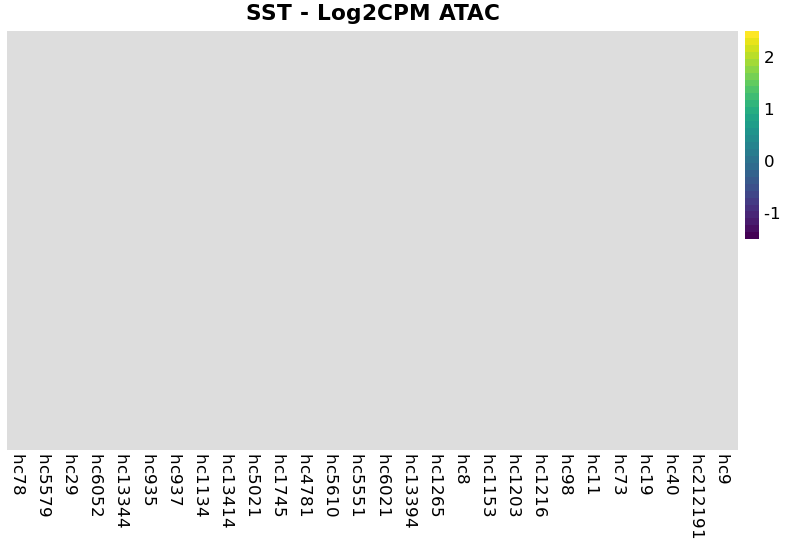

In [153]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [154]:
celltype <- sprintf(cells[10])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [155]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [156]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [157]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [158]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [159]:
comb <- rbind(pcc, pcc_shuf)

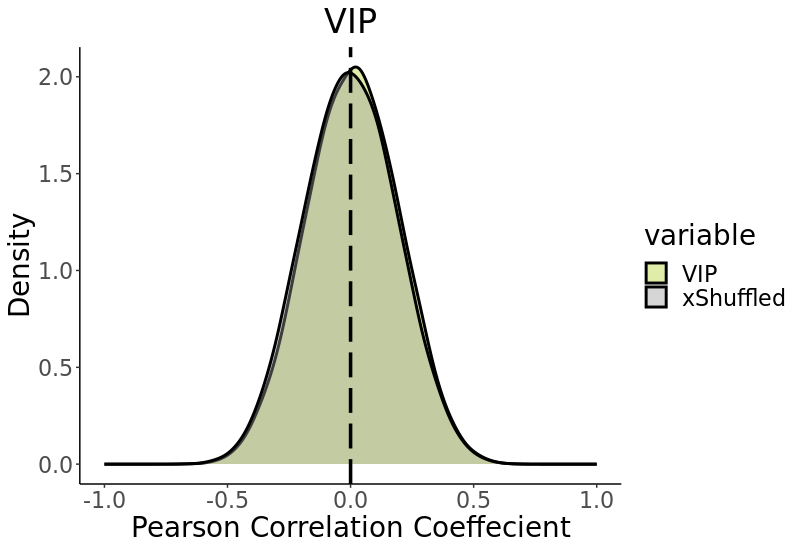

In [160]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [161]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [162]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [163]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [164]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [165]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [166]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [167]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [168]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

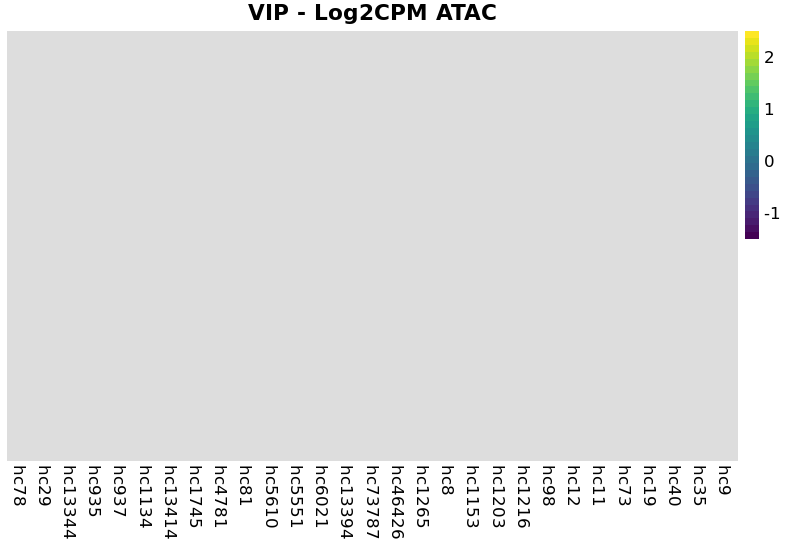

In [169]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [170]:
celltype <- sprintf(cells[11])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [171]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [172]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [173]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [174]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [175]:
comb <- rbind(pcc, pcc_shuf)

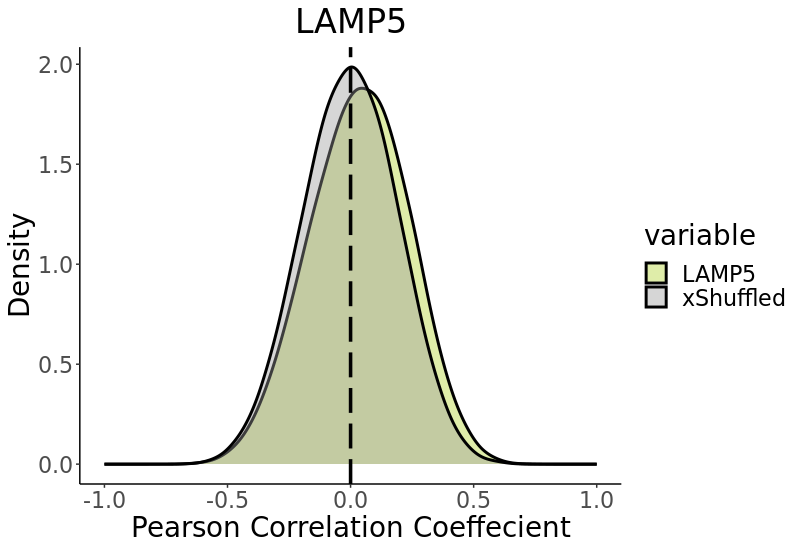

In [176]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [177]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [178]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [179]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [180]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [181]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [182]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [183]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [184]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

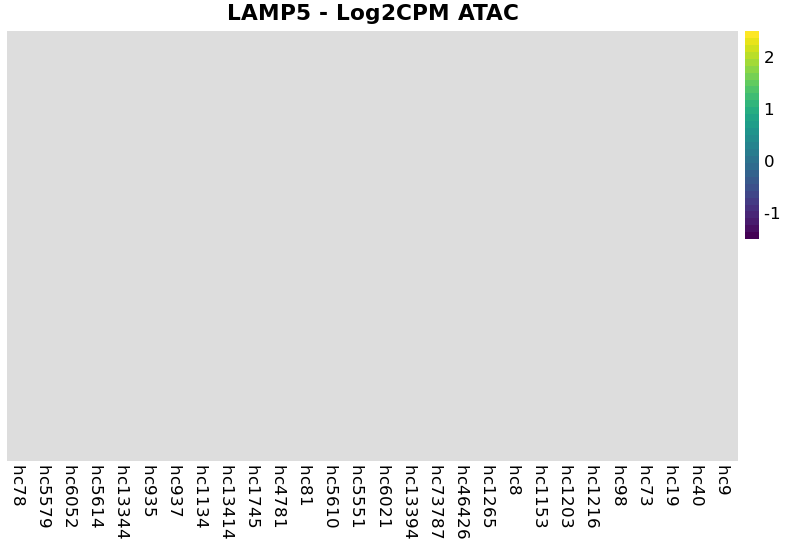

In [185]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [186]:
celltype <- sprintf(cells[12])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [187]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [188]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [189]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [190]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [191]:
comb <- rbind(pcc, pcc_shuf)

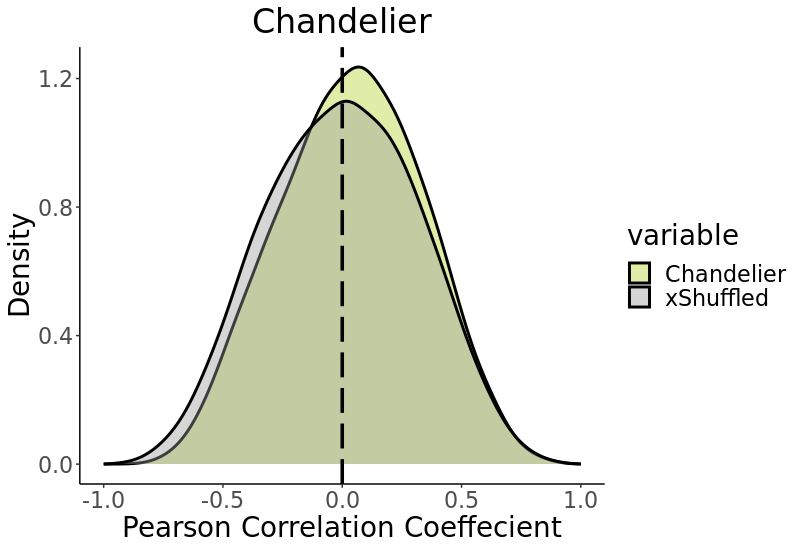

In [192]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [193]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [194]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [195]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [196]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [197]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [198]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [199]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [200]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

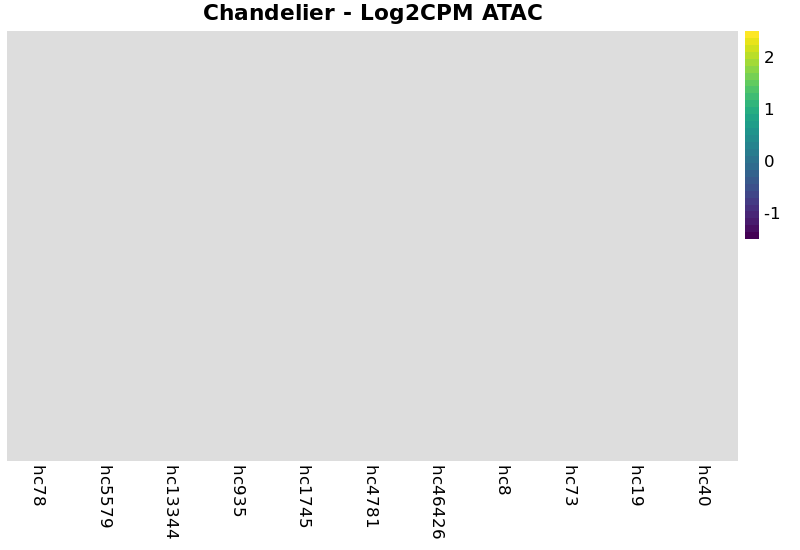

In [201]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [202]:
celltype <- sprintf(cells[13])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [203]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [204]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [205]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [206]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [207]:
comb <- rbind(pcc, pcc_shuf)

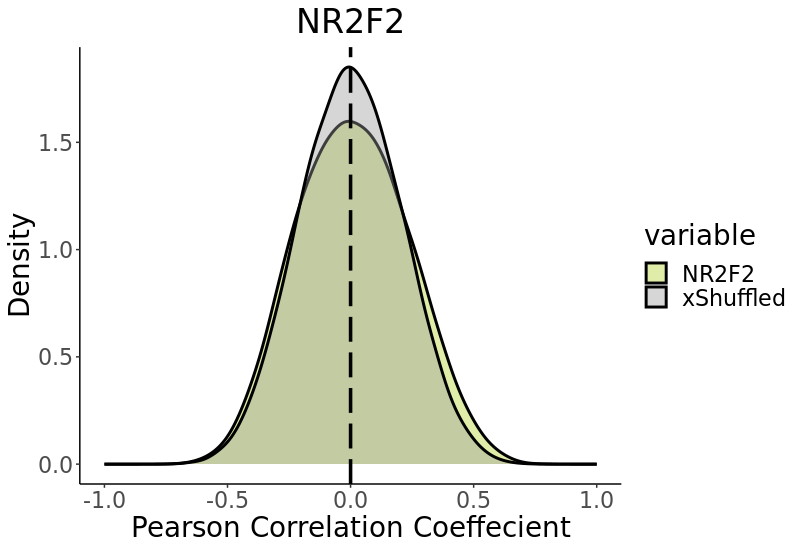

In [208]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [209]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [210]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [211]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [212]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [213]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [214]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [215]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [216]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

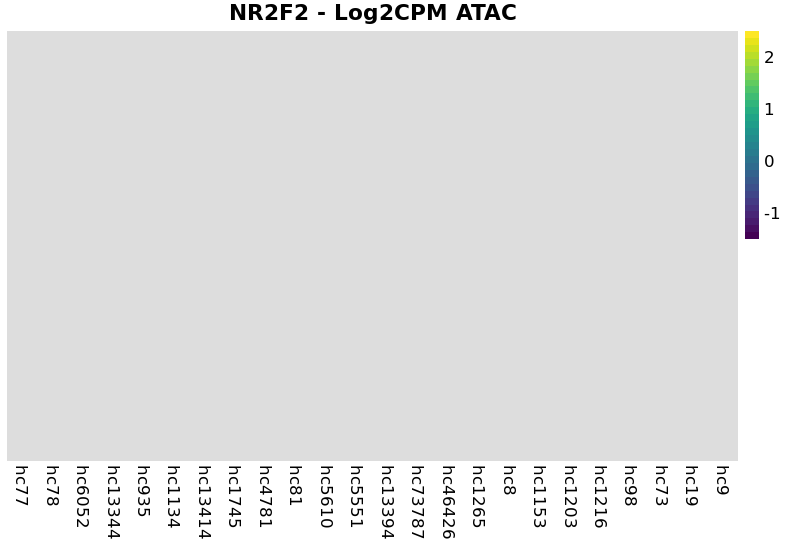

In [217]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [218]:
celltype <- sprintf(cells[14])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [219]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [220]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [221]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [222]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [223]:
comb <- rbind(pcc, pcc_shuf)

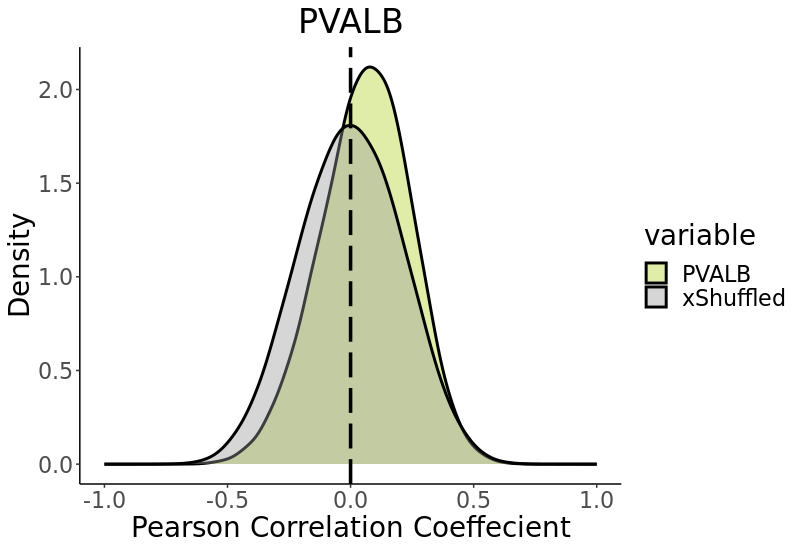

In [224]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [225]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [226]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [227]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [228]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [229]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [230]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [231]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [232]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

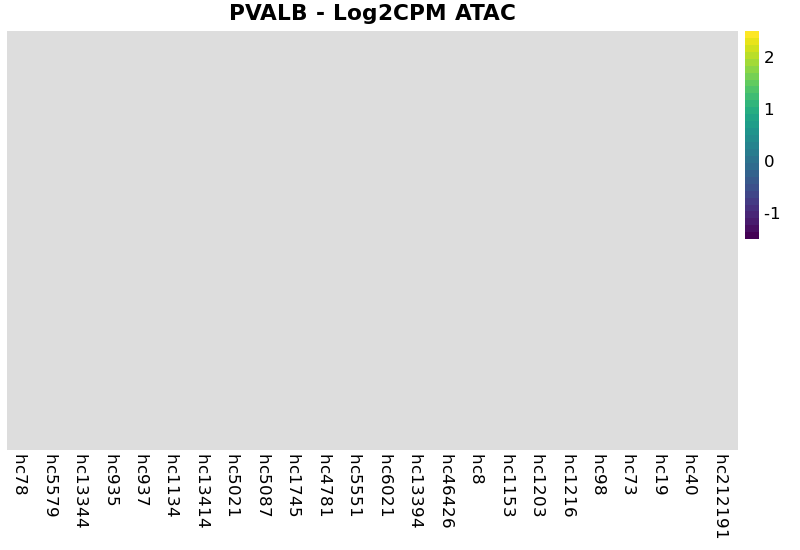

In [233]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [234]:
celltype <- sprintf(cells[15])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [235]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [236]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [237]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [238]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [239]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 1096 rows containing non-finite values (`stat_density()`).”


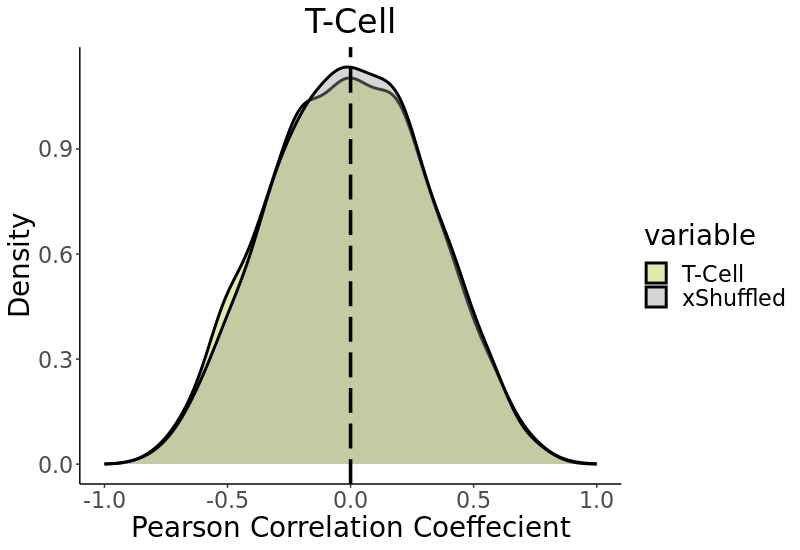

In [240]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [241]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [242]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [243]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [244]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [245]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [246]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [247]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [248]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

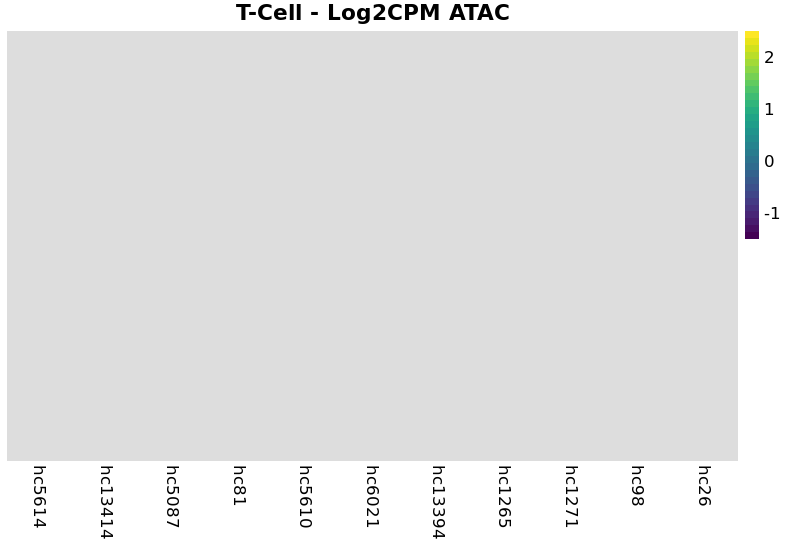

In [249]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [23]:
celltype <- sprintf(cells[16])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [24]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [25]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [26]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [27]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [28]:
comb <- rbind(pcc, pcc_shuf)

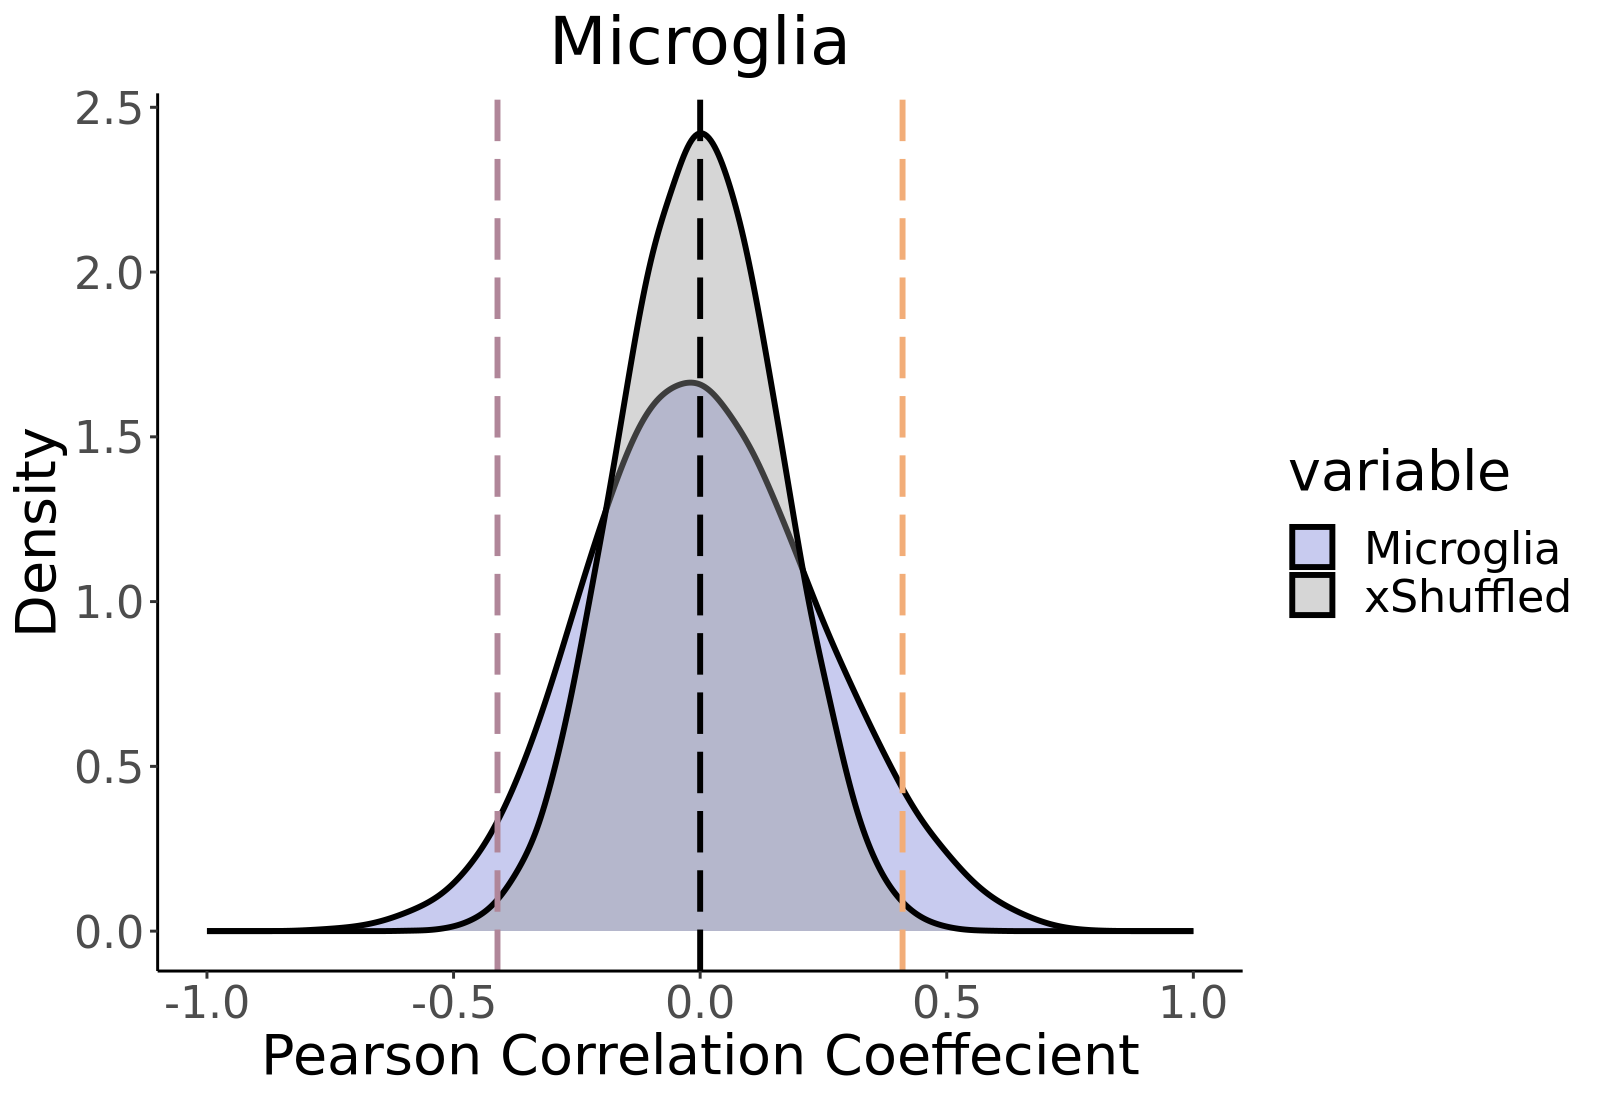

In [32]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
microp <- ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#777ED8","#999999")) +
geom_vline(xintercept=0.4104, col="#F2AD78", linetype="longdash", size=1) +
geom_vline(xintercept=-0.4109, col="#B08699", linetype="longdash", size=1) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

microp
#ggsave("../ggsave/microglia_density_plot_atac_peaks_correlation_B.pdf", plot=microp, font='Helvetica', device="pdf", width=8, height=5.5)

In [25]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [26]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [27]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [28]:
#write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [29]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [30]:
#write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [31]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [32]:
comb <- join(comb, cpm, by = "genes")
write.table(comb, file = 'Microglia_ATAC_up_down_age_cor_peaks.tsv', sep = '\t', row.names=F)
#comb[,1:7] <- NULL

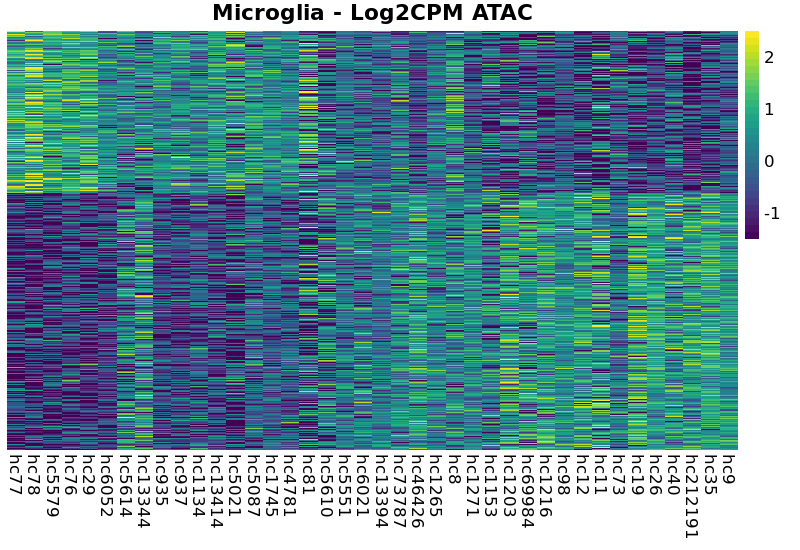

In [19]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
bd <- pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

ggsave("../ggsave/microglia_age_correlated_atac_heatmap.pdf", plot=bd, font='Helvetica', device="pdf", width=8, height=5.5)

In [6]:
celltype <- sprintf(cells[17])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [7]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [8]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [9]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [10]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [11]:
comb <- rbind(pcc, pcc_shuf)

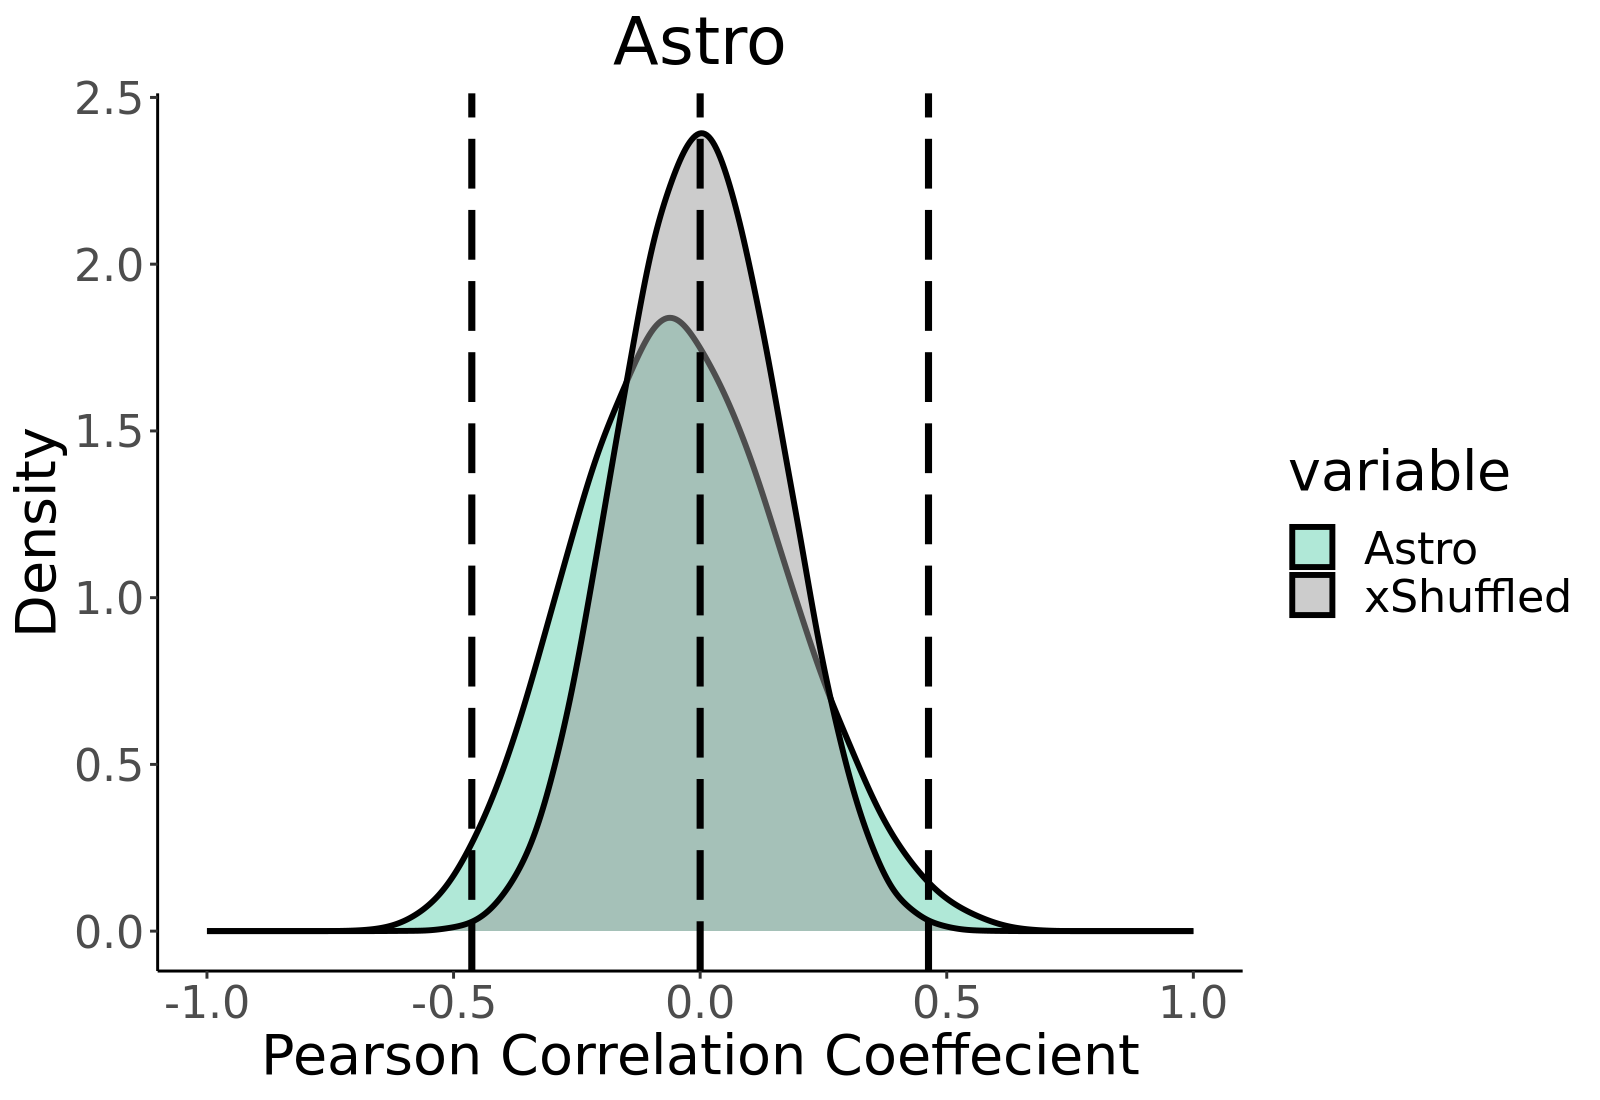

In [17]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 200)
astrop <- ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.5, size=1) +
scale_fill_manual(values=c("#62D1AF","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
geom_vline(xintercept=0.463, col="black", linetype="longdash", size=1.2) +
geom_vline(xintercept=-0.463, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

astrop
#ggsave("../ggsave/astro_density_plot_atac_peaks_correlation.pdf", plot=astrop, font='Helvetica', device="pdf", width=8, height=5.5)

In [273]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [274]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [275]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [276]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [277]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [278]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [279]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [280]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

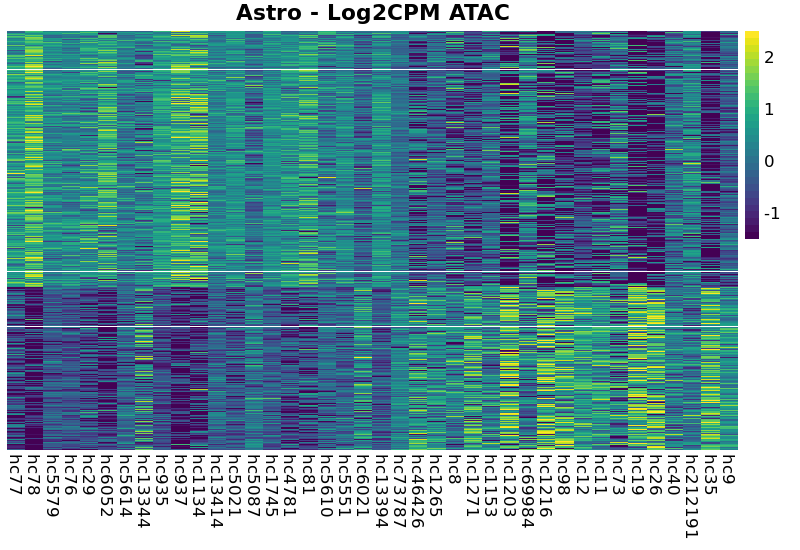

In [281]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [282]:
celltype <- sprintf(cells[18])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [283]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [284]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [285]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [286]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [287]:
comb <- rbind(pcc, pcc_shuf)

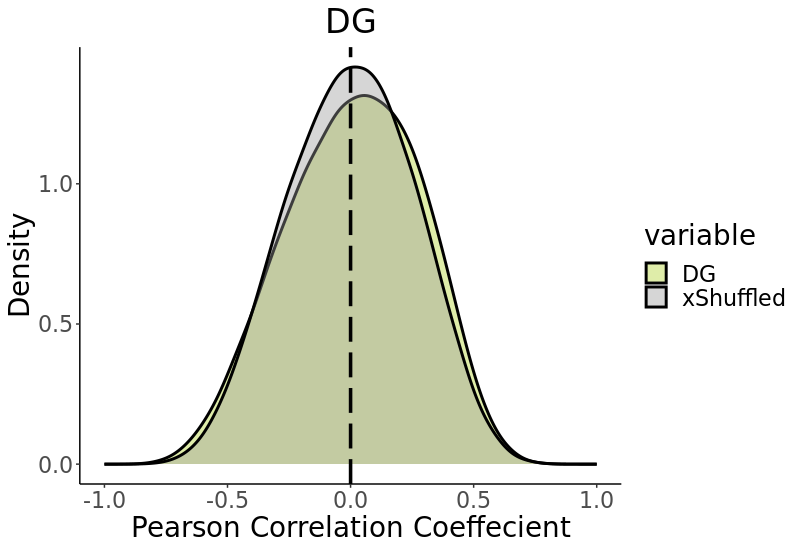

In [288]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [289]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [290]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [291]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [292]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [293]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [294]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [295]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [296]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

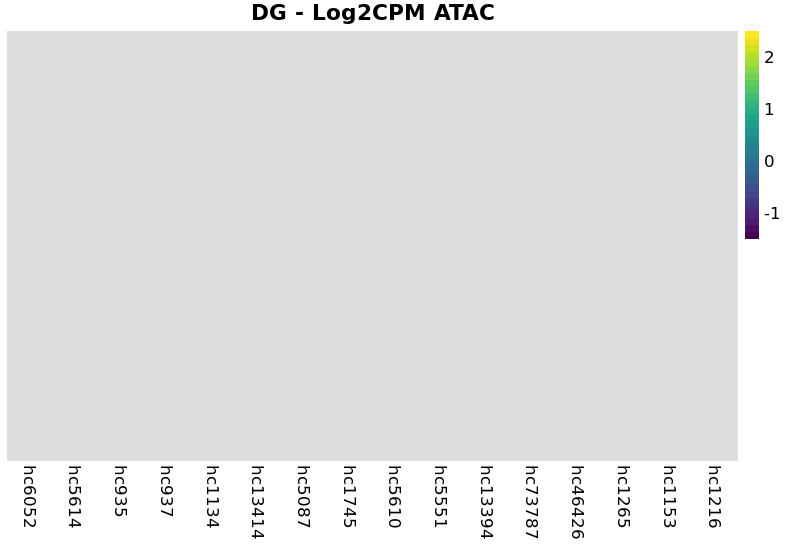

In [297]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [6]:
celltype <- sprintf(cells[19])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [7]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [8]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [9]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [10]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [11]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


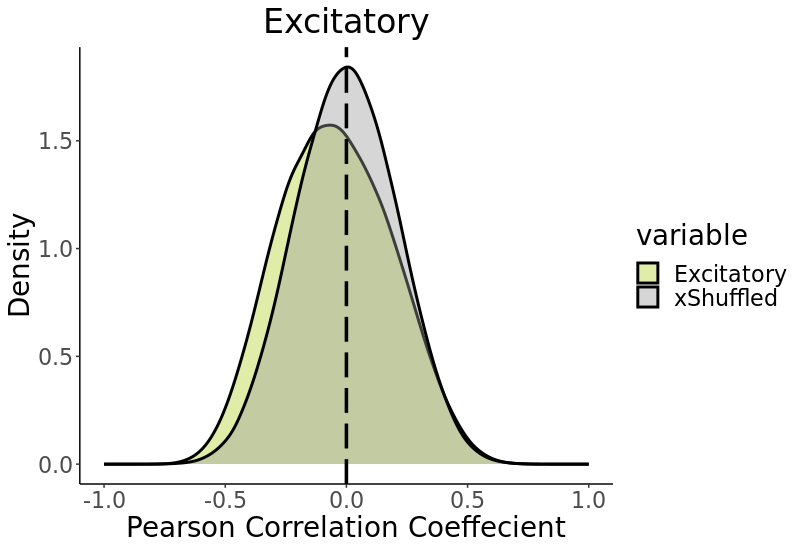

In [12]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [13]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [14]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [15]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [16]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [17]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [18]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [19]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [20]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

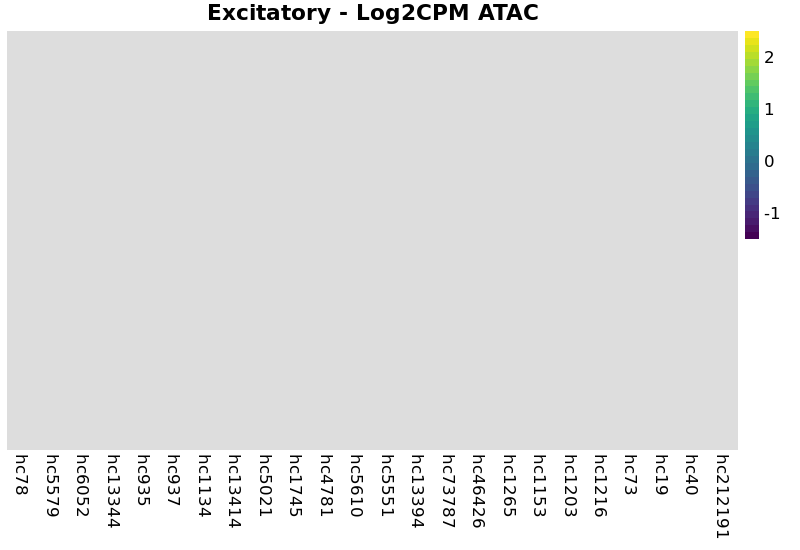

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))

In [22]:
celltype <- sprintf(cells[20])
cpm <- read.table(paste0('../ATAC_cpm/filtered_npeaks_donors/', celltype, '_log2cpm_filtered.tsv', sep=''),
                  header=T, row.names=1)

In [23]:
age1 <- age[age$V1 %in% colnames(cpm),]
age1 <- t(age1[order(age1$V2),])
colnames(age1) <- as.matrix(age1[1,])
age1 <- age1[-1, ]
age1 <- t(age1)
age_mat <- age1[rep(seq_len(nrow(age1)), each = nrow(cpm)), ]
age_mat <- as.data.frame(age_mat)

In [24]:
# calculate pearson correlation 
output= foreach(i=1:nrow(cpm)) %dopar% {
pcc = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$estimate
pcc
}
# combine the list of output. 
pcc = do.call(rbind,output)

In [25]:
# calculate shuffled pearson correlation
cpm_shuf <- randomizeMatrix(cpm, null.model = "richness",iterations = 5000)
age_shuf <- randomizeMatrix(age_mat, null.model = "richness",iterations = 5000)

output_shuf= foreach(i=1:nrow(cpm_shuf)) %dopar% {
pcc_shuf = cor.test(as.numeric(cpm_shuf[i,]),as.numeric(age_shuf[i,]),method="pearson")$estimate
pcc_shuf
}
# combine the list of output. 
pcc_shuf = do.call(rbind,output_shuf)

In [26]:
pcc <- as.data.frame(pcc)
pcc_shuf <- as.data.frame(pcc_shuf)
pcc$variable <- paste0(celltype)
pcc_shuf$variable <- 'xShuffled'

In [27]:
comb <- rbind(pcc, pcc_shuf)

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


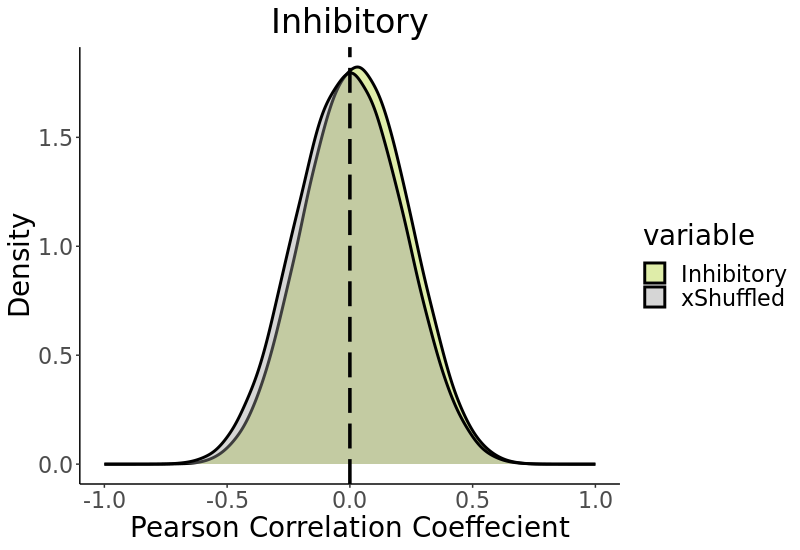

In [28]:
#Filled density plots
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
ggplot(data=comb, aes(x=cor, fill=variable)) +
geom_density(adjust=1.8, alpha=.4, size=1) +
scale_fill_manual(values=c("#B0D229","#999999")) +
geom_vline(xintercept=0, col="black", linetype="longdash", size=1.2) +
xlim(-1, 1) +
theme_classic() + labs(title=celltype, x ="Pearson Correlation Coeffecient", y = "Density") +
theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))

In [29]:
output= foreach(i=1:nrow(cpm)) %dopar% {
pval = cor.test(as.numeric(cpm[i,]),as.numeric(age_mat[i,]),method="pearson")$p.value
pval
}
pval = do.call(rbind,output)
pval = as.data.frame(pval)
colnames(pval) <- 'pval'
pval$fdr <- p.adjust(pval$pval, "fdr")

In [30]:
comb <- cbind(pcc, pval)
rownames(comb) <- rownames(cpm)

In [31]:
comb$log10fdr <- -log10(comb$fdr)
comb$Age_Correlated <- "No"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor > 0] <- "Up"
comb$Age_Correlated[comb$fdr < 0.1 & comb$cor < 0] <- "Down"

In [32]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_ATAC_pcc_donor_counts_filt_donors.tsv'), sep = '\t')

In [33]:
comb <- comb[!grepl("No",comb$Age_Correlated),]
comb <- comb[sample(1:nrow(comb)), ]
#comb <- comb[order(comb$cor),]
comb <- comb[order(comb$Age_Correlated),]

In [34]:
write.table(comb, file = paste0('ATAC_age_correlation/', celltype, '_pcc_fdr_0.1.tsv'), sep = '\t')

In [35]:
comb$genes <- rownames(comb)
cpm$genes <- rownames(cpm)

In [36]:
comb <- join(comb, cpm, by = "genes")
comb[,1:7] <- NULL

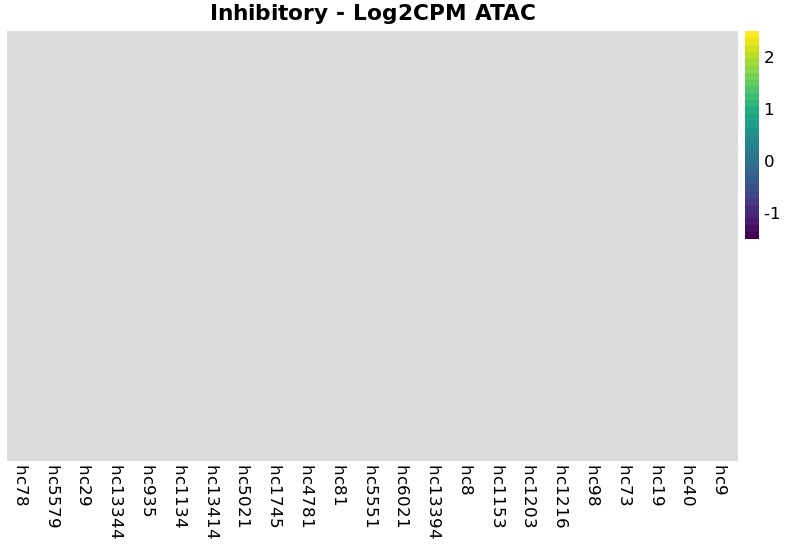

In [37]:
options(repr.plot.width = 8, repr.plot.height = 5.5, repr.plot.res = 100)
pheatmap(mat=comb, scale = 'row', color = viridis(30), breaks = seq(-1.5, 2.5, by = 4/30), border_color = NA, 
         cluster_cols = F, cluster_rows = F, show_colnames = TRUE, show_rownames = FALSE, 
         fontsize = 12, main = paste0(celltype, " - Log2CPM ATAC"))